# Muffin vs Chihuahua

**Dataset**: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/data

## Import libs

In [5]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Auxiliar set up

In [6]:
# Set GPU visibility (if necessary)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Data Augmentation and Loading

### Data Augmentation function

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

### Load data

In [8]:
# Load validation data with augmentation (no extra augmentation for validation)
train_generator = train_datagen.flow_from_directory(
    'datasets/muffin-vs-chihuahua/train',
    target_size=(200, 200),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

# Load validation data with augmentation (no extra augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    'datasets/muffin-vs-chihuahua/train',
    target_size=(200, 200),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Load test data (rescaling only)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'datasets/muffin-vs-chihuahua/test',
    target_size=(200, 200),
    batch_size=32,
    class_mode='sparse'
)

Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


## Model Architecture

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(200, 200, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation=tf.nn.relu),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Adjusted to 2 output classes
])

model.summary()

/home/pedro/ESESA/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    40,960,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,055,682 (156.61 MB)

 Trainable params: 41,055,234 (156.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Model Compilation and Training

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8106 - loss: 0.6138 - val_accuracy: 0.8071 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9062 - loss: 0.2241 - val_accuracy: 0.8157 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8490 - loss: 0.4090 - val_accuracy: 0.5593 - val_loss: 1.6277 - learning_rate: 0.0010
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.7812 - loss: 0.4766 - val_accuracy: 0.5679 - val_loss: 1.5965 - learning_rate: 0.0010
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8204 - loss: 0.5072 - val_accuracy: 0.8319 - val_loss: 0.8456 - learning_rate: 0.0010
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8750 - loss: 0.2344 - val_accuracy: 0.8276 - val_loss: 0.8751 - learning_rate: 2.0000e-04
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8768 - l

## Training stats

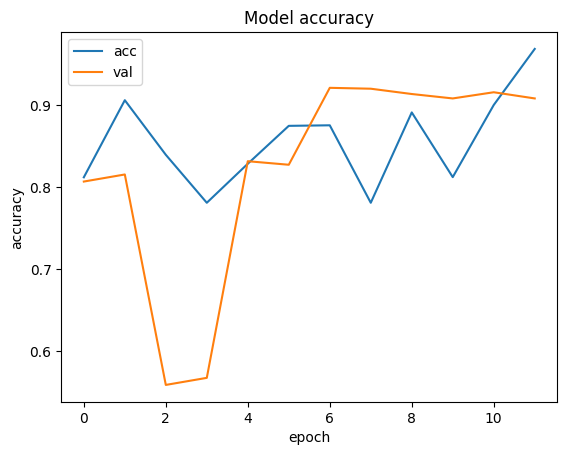

In [19]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val'], loc='upper left')
plt.show()

## Prediction function

In [20]:
def predict_image(model, image_path, target_size=(200, 200)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    return prediction

## Image prediction

In [32]:
from IPython.display import Image, display
class_labels = ['chihuahua', 'muffin']

In [36]:
def display_and_predict(image_path, model, class_labels):
    """
    Display an image and perform prediction using a pre-trained model.
    
    Args:
        image_path (str): Path to the image file
        model: Trained model for prediction
        class_labels (list): List of class labels corresponding to model outputs
    
    Returns:
        tuple: (predicted_class, confidence) or (None, None) if error occurs
    
    Raises:
        FileNotFoundError: If image file doesn't exist
        ValueError: If model or class_labels are invalid
    """
    try:
        # Validate inputs
        if not model:
            raise ValueError("Model cannot be None")
        if not class_labels or not isinstance(class_labels, (list, np.ndarray)):
            raise ValueError("Invalid class labels")
            
        # Display image
        from IPython.display import Image, display
        display(Image(image_path))
        
        # Make prediction
        prediction = predict_image(model, image_path)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction)
        
        # Print results
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}")
        
        return predicted_class, confidence
        
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

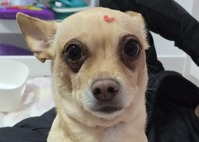

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class: chihuahua
Confidence: 1.00


In [38]:
predicted_class_1, confidence_1 = display_and_predict('pictures/1.jpg', model, class_labels)

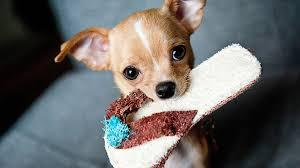

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class: chihuahua
Confidence: 0.95


In [39]:
predicted_class_2, confidence_2 = display_and_predict('pictures/2.jpg', model, class_labels)

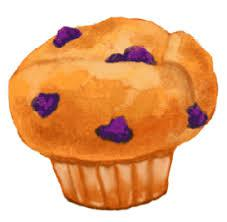

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: muffin
Confidence: 0.95


In [40]:
predicted_class_3, confidence_4 = display_and_predict('pictures/3.jpg', model, class_labels)